In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Định dạng hiển thị đồ thị đẹp hơn
plt.style.use('fivethirtyeight')

In [2]:
# Lấy dữ liệu từ 01/01/2010 đến 01/01/2014
stock_symbol = 'AAPL'  # Thay bằng mã cổ phiếu khác nếu muốn
data = yf.download(stock_symbol, start="2010-01-01", end="2014-01-01")

# Hiển thị 5 dòng đầu tiên
data.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.440331,6.455077,6.391278,6.422877,493729600
2010-01-05,6.451466,6.487879,6.417460,6.458087,601904800
2010-01-06,6.348846,6.477045,6.342226,6.451466,552160000
2010-01-07,6.337111,6.379845,6.291068,6.372321,477131200
2010-01-08,6.379240,6.379842,6.291367,6.328682,447610800


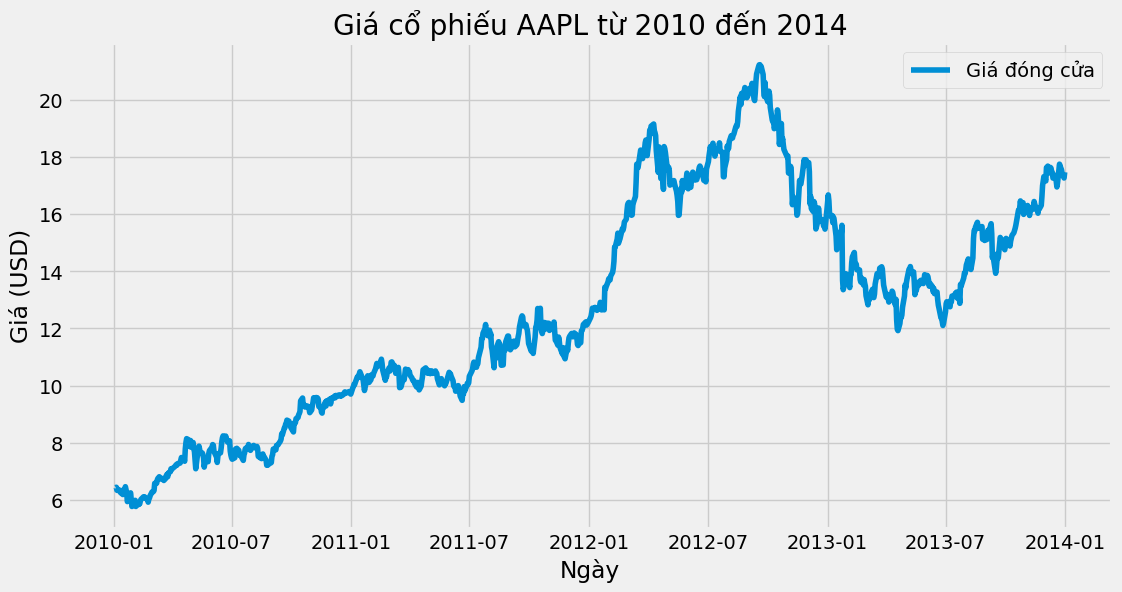

In [3]:
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Giá đóng cửa')
plt.title(f'Giá cổ phiếu {stock_symbol} từ 2010 đến 2014')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.legend()
plt.show()


In [4]:
# Lấy dữ liệu cột "Close"
df_close = data[['Close']].values

# Chuẩn hóa dữ liệu về khoảng [0,1] để dễ huấn luyện mô hình
scaler = MinMaxScaler(feature_range=(0,1))
df_close_scaled = scaler.fit_transform(df_close)

# Xem thử dữ liệu sau khi chuẩn hóa
df_close_scaled[:5]


array([[0.04280163],
       [0.04352281],
       [0.03687645],
       [0.03611641],
       [0.03884492]])

In [5]:
# Số ngày dùng để dự đoán
time_step = 60  

X, y = [], []
for i in range(time_step, len(df_close_scaled)):
    X.append(df_close_scaled[i-time_step:i, 0])  # Lấy 60 ngày trước đó
    y.append(df_close_scaled[i, 0])  # Giá ngày kế tiếp

# Chuyển thành numpy array
X, y = np.array(X), np.array(y)

# Reshape lại dữ liệu để phù hợp với LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

X.shape, y.shape


((946, 60, 1), (946,))

In [6]:
train_size = int(len(X) * 0.8)  # 80% dữ liệu để train
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

X_train.shape, X_test.shape


((756, 60, 1), (190, 60, 1))

In [7]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),

    LSTM(units=50, return_sequences=True),
    Dropout(0.2),

    LSTM(units=50),
    Dropout(0.2),

    Dense(units=1)  # Dự đoán giá trị tiếp theo
])

# Compile mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Hiển thị kiến trúc mô hình
model.summary()


C:\Users\TANKUTO\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - loss: 0.0787 - val_loss: 0.0036
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.0078 - val_loss: 0.0023
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.0058 - val_loss: 0.0025
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0045 - val_loss: 0.0020
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.0047 - val_loss: 0.0019
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.0054 - val_loss: 0.0019
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0039 - val_loss: 0.0018
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0040 - val_loss: 0.0021
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.0050 - val_loss: 0.0026
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/ste

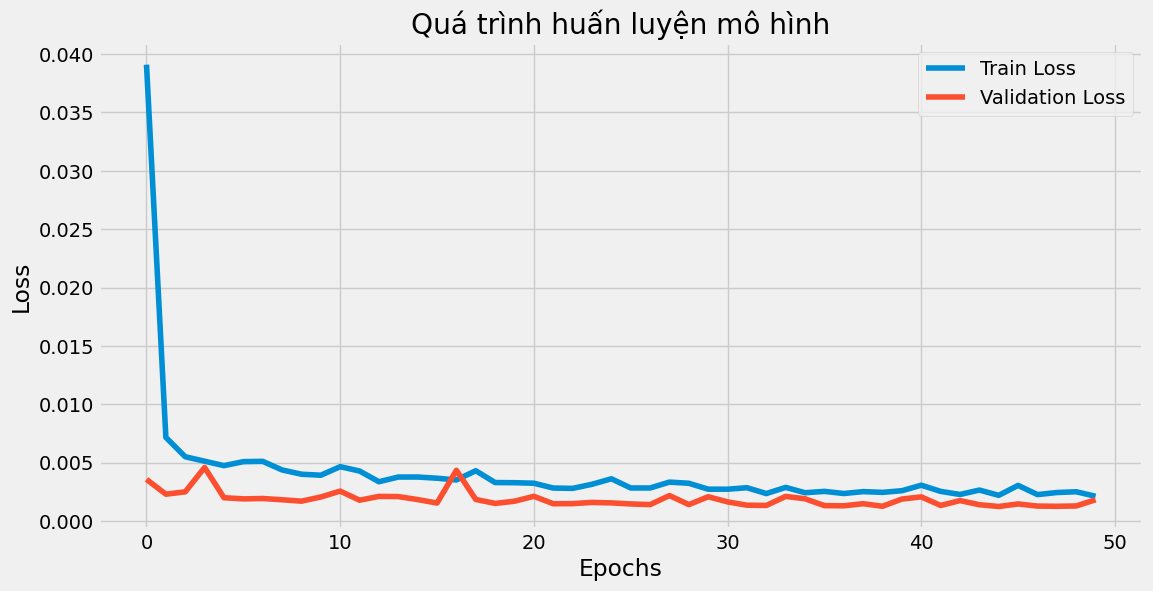

In [9]:

plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Quá trình huấn luyện mô hình')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step


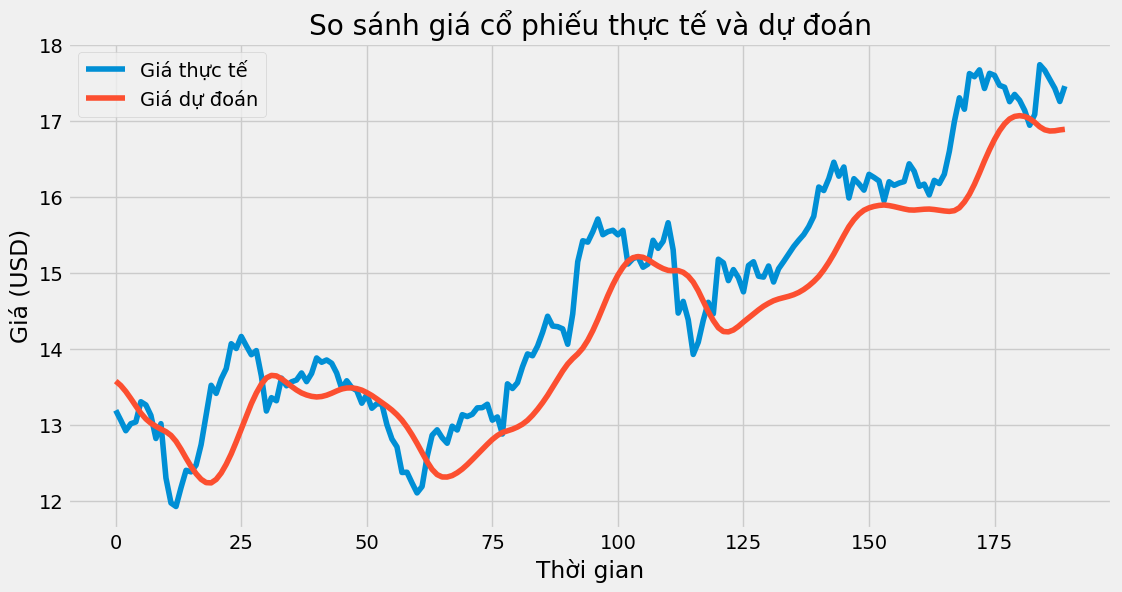

In [10]:


# Dự đoán trên tập test
predicted_prices = model.predict(X_test)

# Chuyển dữ liệu về giá trị gốc
predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1,1))
real_prices = scaler.inverse_transform(y_test.reshape(-1,1))

# Vẽ biểu đồ so sánh
plt.figure(figsize=(12,6))
plt.plot(real_prices, label='Giá thực tế')
plt.plot(predicted_prices, label='Giá dự đoán')
plt.title('So sánh giá cổ phiếu thực tế và dự đoán')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USD)')
plt.legend()
plt.show()


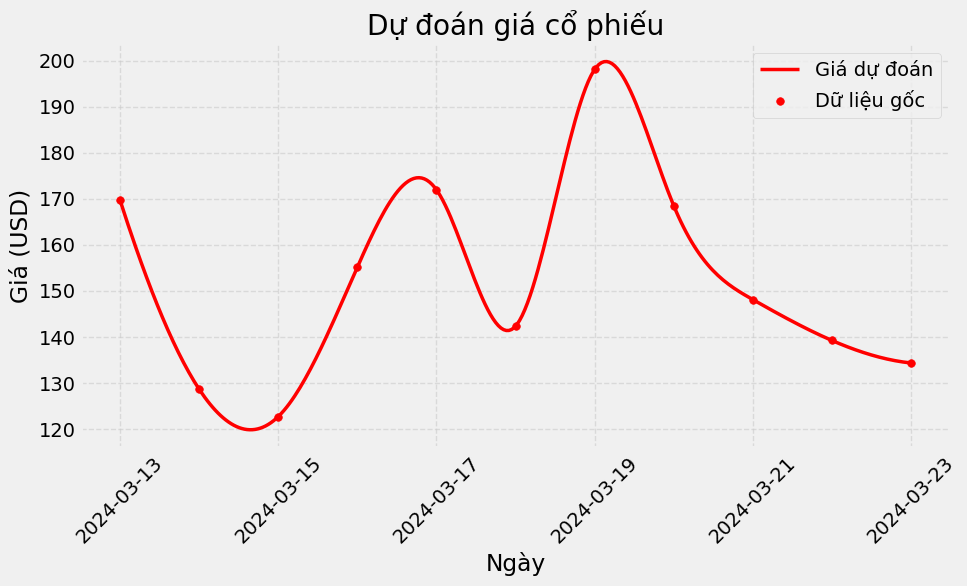

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Tạo danh sách ngày dự đoán
future_days = 11
future_dates = pd.date_range(start="2024-03-13", periods=future_days)

np.random.seed(123)  # Đặt seed để kết quả ngẫu nhiên có thể tái lập
# Giả lập giá cổ phiếu dự đoán
future_predictions = np.random.uniform(100, 200, size=future_days)

# Chuyển đổi ngày thành số để vẽ đồ thị
x = np.array([date.toordinal() for date in future_dates])
y = np.array(future_predictions.flatten())

# Tạo đường spline mượt hơn
x_smooth = np.linspace(x.min(), x.max(), 300)
spline = make_interp_spline(x, y, k=3)
y_smooth = spline(x_smooth)

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
plt.plot(x_smooth, y_smooth, label="Giá dự đoán", color="red", linewidth=2.5)
plt.scatter(x, y, color="red", s=30, label="Dữ liệu gốc")

# Cấu hình biểu đồ
plt.xlabel("Ngày")
plt.ylabel("Giá (USD)")
plt.title("Dự đoán giá cổ phiếu")
plt.xticks(x[::2], [date.strftime('%Y-%m-%d') for date in future_dates[::2]], rotation=45)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [12]:
print("Ngày dự đoán:", future_dates)
print("Giá dự đoán:", future_predictions.flatten())  # Chuyển về dạng list dễ đọc


Ngày dự đoán: DatetimeIndex(['2024-03-13', '2024-03-14', '2024-03-15', '2024-03-16',
               '2024-03-17', '2024-03-18', '2024-03-19', '2024-03-20',
               '2024-03-21', '2024-03-22'],
              dtype='datetime64[ns]', freq='D')
Giá dự đoán: [140.92351555 198.32913958 179.92085439 183.19564389 165.95974386
 165.85056299 117.97566086 131.93272135 193.9527323  187.20512986]
